In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv("../data/schemas/warm_up/TrainSet.csv", sep=",")
test = pd.read_csv("../data/schemas/warm_up/TestSet.csv", sep=",")

In [3]:
NUM_OF_TIMESTEPS_INPUT = 48
NUM_OF_TIMESTEPS_OUTPUT = 24

In [4]:
threshold = 0
column_to_predict = "kg_CO2/kWh"

independent_variables = []


for column in train:
    if abs(train[column].corr(train[column_to_predict])) > threshold:
        independent_variables.append(column)

# independent_variables.remove(column_to_predict)
if "Index" in independent_variables:
    independent_variables.remove("Index")
independent_variables

['Hour_1',
 'Day Type_1',
 'Indoor Temperature (C)_1',
 'Average Unmet Cooling Setpoint Difference (C)_1',
 'Indoor Relative Humidity (%)_1',
 'Equipment Electric Power (kWh)_1',
 'DHW Heating (kWh)_1',
 'Cooling Load (kWh)_1',
 'Solar Generation (W/kW)_1',
 'Occupant Count (people)_1',
 'Temperature Set Point (C)_1',
 'Hour_2',
 'Day Type_2',
 'Indoor Temperature (C)_2',
 'Average Unmet Cooling Setpoint Difference (C)_2',
 'Indoor Relative Humidity (%)_2',
 'Equipment Electric Power (kWh)_2',
 'DHW Heating (kWh)_2',
 'Cooling Load (kWh)_2',
 'Solar Generation (W/kW)_2',
 'Occupant Count (people)_2',
 'Temperature Set Point (C)_2',
 'Hour_3',
 'Day Type_3',
 'Indoor Temperature (C)_3',
 'Average Unmet Cooling Setpoint Difference (C)_3',
 'Indoor Relative Humidity (%)_3',
 'Equipment Electric Power (kWh)_3',
 'DHW Heating (kWh)_3',
 'Cooling Load (kWh)_3',
 'Solar Generation (W/kW)_3',
 'Occupant Count (people)_3',
 'Temperature Set Point (C)_3',
 'Outdoor Drybulb Temperature (C)',
 'Ou

In [5]:
X_train = train[independent_variables]
# X_train = train[["Hour_1", "Day Type_1"]]
Y_train = train[column_to_predict]

X_train.head()
rows, num_of_columns = X_train.shape

In [6]:
def create_sequences(input_data, output_data, timesteps_input, timesteps_output):
    sequences, targets = [], []
    for i in range(len(input_data) - timesteps_input - timesteps_output + 1):
        seq = input_data[i:i + timesteps_input]
        #print(f"i = {i}, seq = {seq}")
        target = output_data[i + timesteps_input: i + timesteps_input + timesteps_output]
        #print(f"i = {i}, target = {target}")
        sequences.append(seq)
        targets.append(target)

    return np.array(sequences), np.array(targets)

In [7]:
input_sequences, target_variables = create_sequences(X_train, Y_train, NUM_OF_TIMESTEPS_INPUT, NUM_OF_TIMESTEPS_OUTPUT)
print(input_sequences[0])
print(target_variables[0])
print(input_sequences.shape)
print(target_variables.shape)

[[0.         0.66666667 0.42905032 ... 0.         0.29729497 0.        ]
 [0.04347826 0.66666667 0.30943362 ... 0.         0.20640526 0.        ]
 [0.08695652 0.66666667 0.30781619 ... 0.         0.14616055 0.        ]
 ...
 [0.91304348 0.83333333 0.29064017 ... 0.         0.5514706  0.        ]
 [0.95652174 0.83333333 0.04895782 ... 0.         0.55391621 0.        ]
 [1.         0.83333333 0.00208331 ... 0.         0.53771165 0.        ]]
[0.59739428 0.49429981 0.38708765 0.28880037 0.2346659  0.22880156
 0.26241434 0.31385395 0.36274065 0.32912399 0.41859464 0.59690114
 0.74685743 0.82796725 0.84589733 0.83725959 0.82125879 0.80709442
 0.78806505 0.73835998 0.71748058 0.73547528 0.69513525 0.71729728]
(577, 48, 51)
(577, 24)


In [8]:
# importing libraries
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.optimizers import SGD

In [9]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits = 4) # For cross-validation

callback = keras.callbacks.EarlyStopping(monitor='loss', patience = 5) #patience parameter to be adjusted

loss = []
val_loss = []

for train_data, test_data in tscv.split(input_sequences):
    X_train, X_test = input_sequences[train_data], input_sequences[test_data]
    y_train, y_test = target_variables[train_data], target_variables[test_data]
    
    model = keras.Sequential([        
        keras.layers.GRU(48, activation='tanh', input_shape=(input_sequences.shape[1], input_sequences.shape[2]), return_sequences=True),
        # keras.layers.Dropout(0.2),   no dropout yet
        keras.layers.GRU(48, activation='tanh', return_sequences=True),
        keras.layers.GRU(24, activation='tanh', return_sequences=False),
        keras.layers.Dense(24)
    ]) #amount of layers & neurons to be adjusted


    model.compile(
        optimizer='adam',
        loss= 'mse'
    ) #types of optimizer, loss function to be adjusted
    
    history = model.fit(X_train, y_train,
              epochs=100, 
              validation_data=(X_test, y_test),
              # validation_split = 0.8,
              verbose=1,
              #callbacks=callback
    )
    
    loss.append(model.history.history['loss'])
    val_loss.append(model.history.history['val_loss'])

Epoch 1/100
4/4 [==============================] - 5s 281ms/step - loss: 0.3880 - val_loss: 0.1737
Epoch 2/100
4/4 [==============================] - 0s 39ms/step - loss: 0.2511 - val_loss: 0.1513
Epoch 3/100
4/4 [==============================] - 0s 39ms/step - loss: 0.2035 - val_loss: 0.1306
Epoch 4/100
4/4 [==============================] - 0s 38ms/step - loss: 0.1616 - val_loss: 0.0931
Epoch 5/100
4/4 [==============================] - 0s 38ms/step - loss: 0.1237 - val_loss: 0.0710
Epoch 6/100
4/4 [==============================] - 0s 37ms/step - loss: 0.0970 - val_loss: 0.0623
Epoch 7/100
4/4 [==============================] - 0s 38ms/step - loss: 0.0760 - val_loss: 0.0560
Epoch 8/100
4/4 [==============================] - 0s 37ms/step - loss: 0.0614 - val_loss: 0.0525
Epoch 9/100
4/4 [==============================] - 0s 38ms/step - loss: 0.0532 - val_loss: 0.0520
Epoch 10/100
4/4 [==============================] - 0s 38ms/step - loss: 0.0486 - val_loss: 0.0515
Epoch 11/100
4/4 [

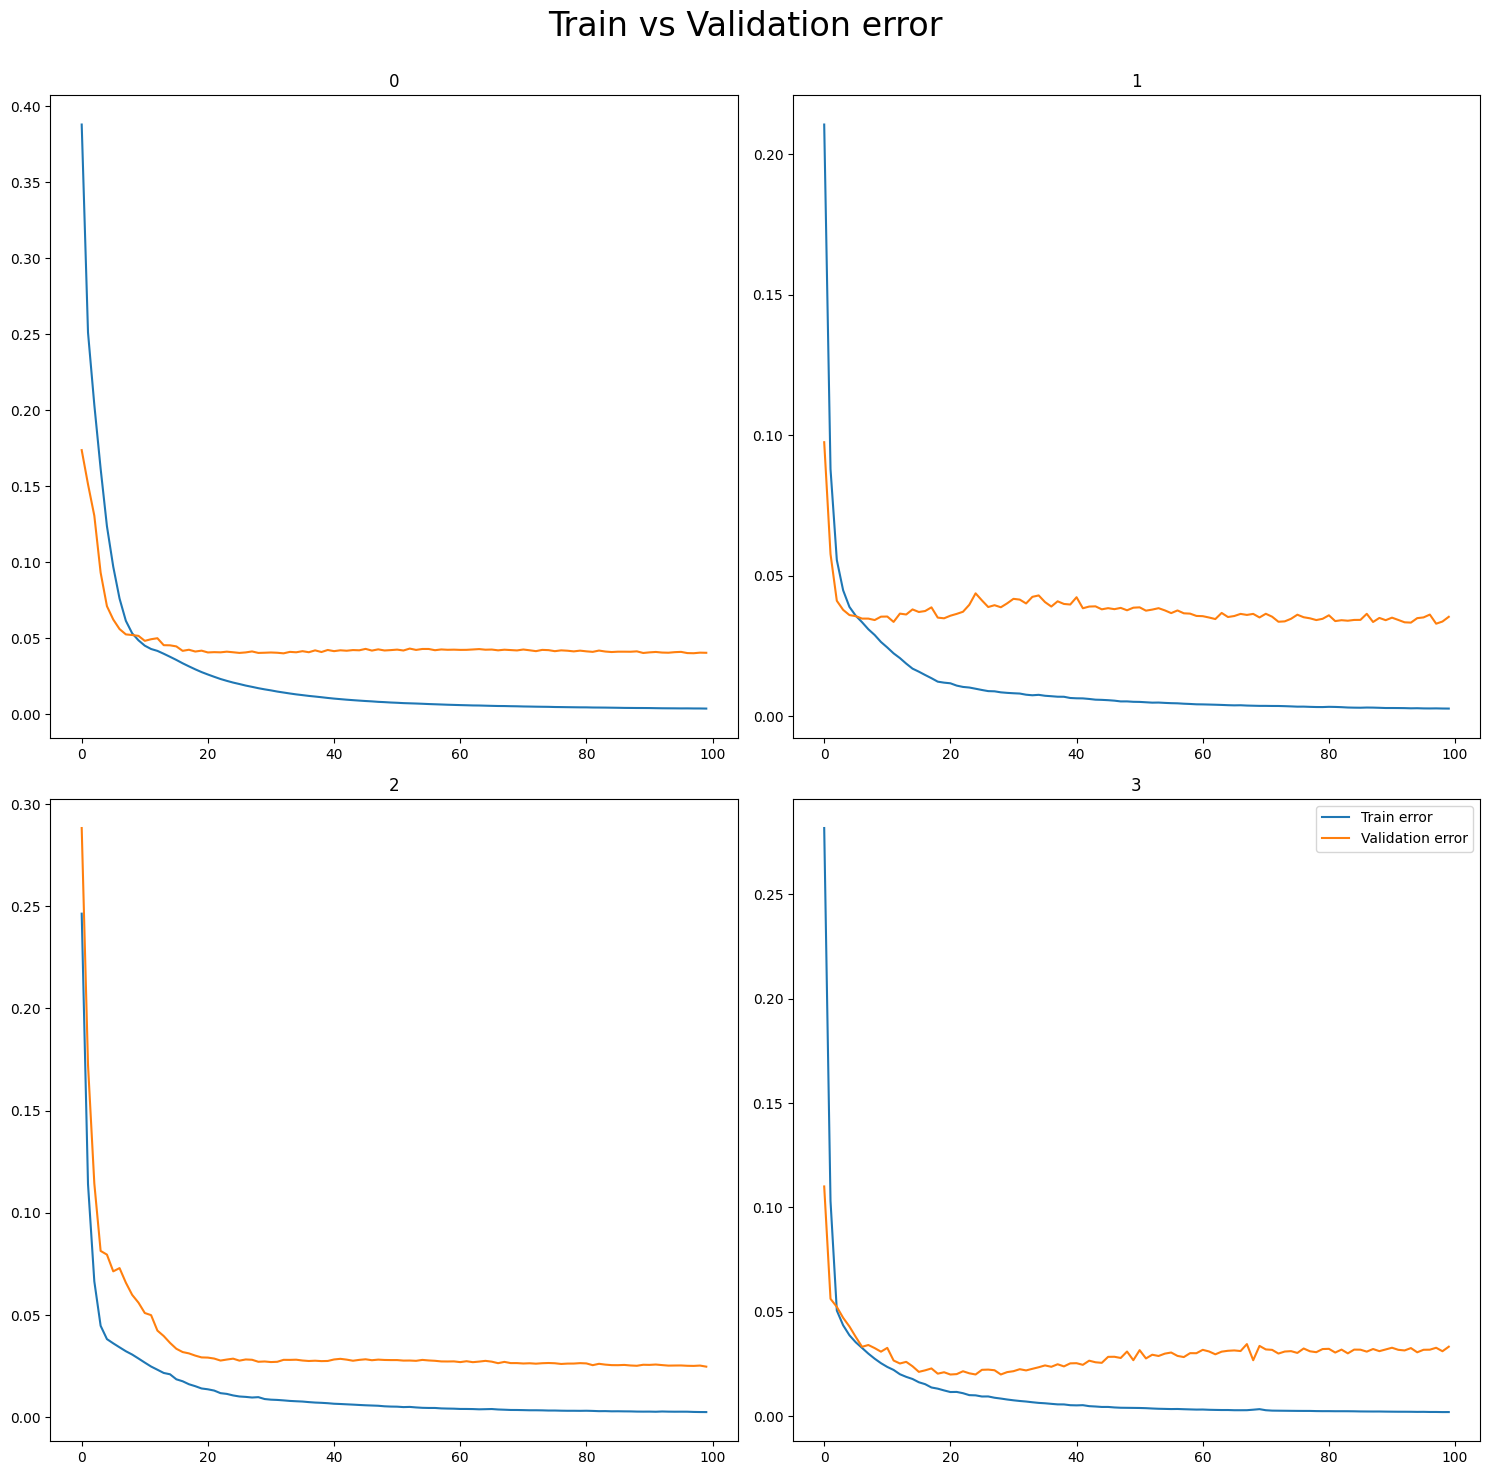

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs = axs.flatten()

for i, column in enumerate(loss):
    ax = axs[i]
    ax.plot(column, label="Train error")
    ax.plot(val_loss[i], label="Validation error")
    ax.title.set_text(i)
    
fig.suptitle("Train vs Validation error", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.legend()
plt.show()

In [11]:
X_train = train[independent_variables]
Y_train = train[column_to_predict]

# Prepare data for evaluation
X_test = test[independent_variables]
# X_test = train[["Hour_1", "Day Type_1"]]
Y_test = test[column_to_predict]

# Append last 24 hours from train
last_24_X = X_train.tail(24)
last_24_Y = Y_train.tail(24)

X_test = pd.concat([last_24_X, X_test], ignore_index=True)
Y_test = pd.concat([last_24_Y, Y_test], ignore_index=True)

eval_input_sequences, eval_target_variables = create_sequences(X_test, Y_test, NUM_OF_TIMESTEPS_INPUT, NUM_OF_TIMESTEPS_OUTPUT)
print(Y_test)
print(eval_input_sequences.shape)
print(eval_target_variables.shape)

0     0.353082
1     0.256588
2     0.215438
3     0.201465
4     0.186162
        ...   
91    0.587037
92    0.607686
93    0.571493
94    0.508506
95    0.414290
Name: kg_CO2/kWh, Length: 96, dtype: float64
(25, 48, 51)
(25, 24)


In [12]:
# Evaluate the model on the test data
predictions = []
#print(len(eval_target_variables))

for i in range(len(eval_target_variables)):
    current_batch = eval_input_sequences[i].reshape((1, NUM_OF_TIMESTEPS_INPUT, num_of_columns))
    curr_pred = model.predict(current_batch)
    predictions.append(curr_pred)

1/1 [==============================] - 0s 22ms/step


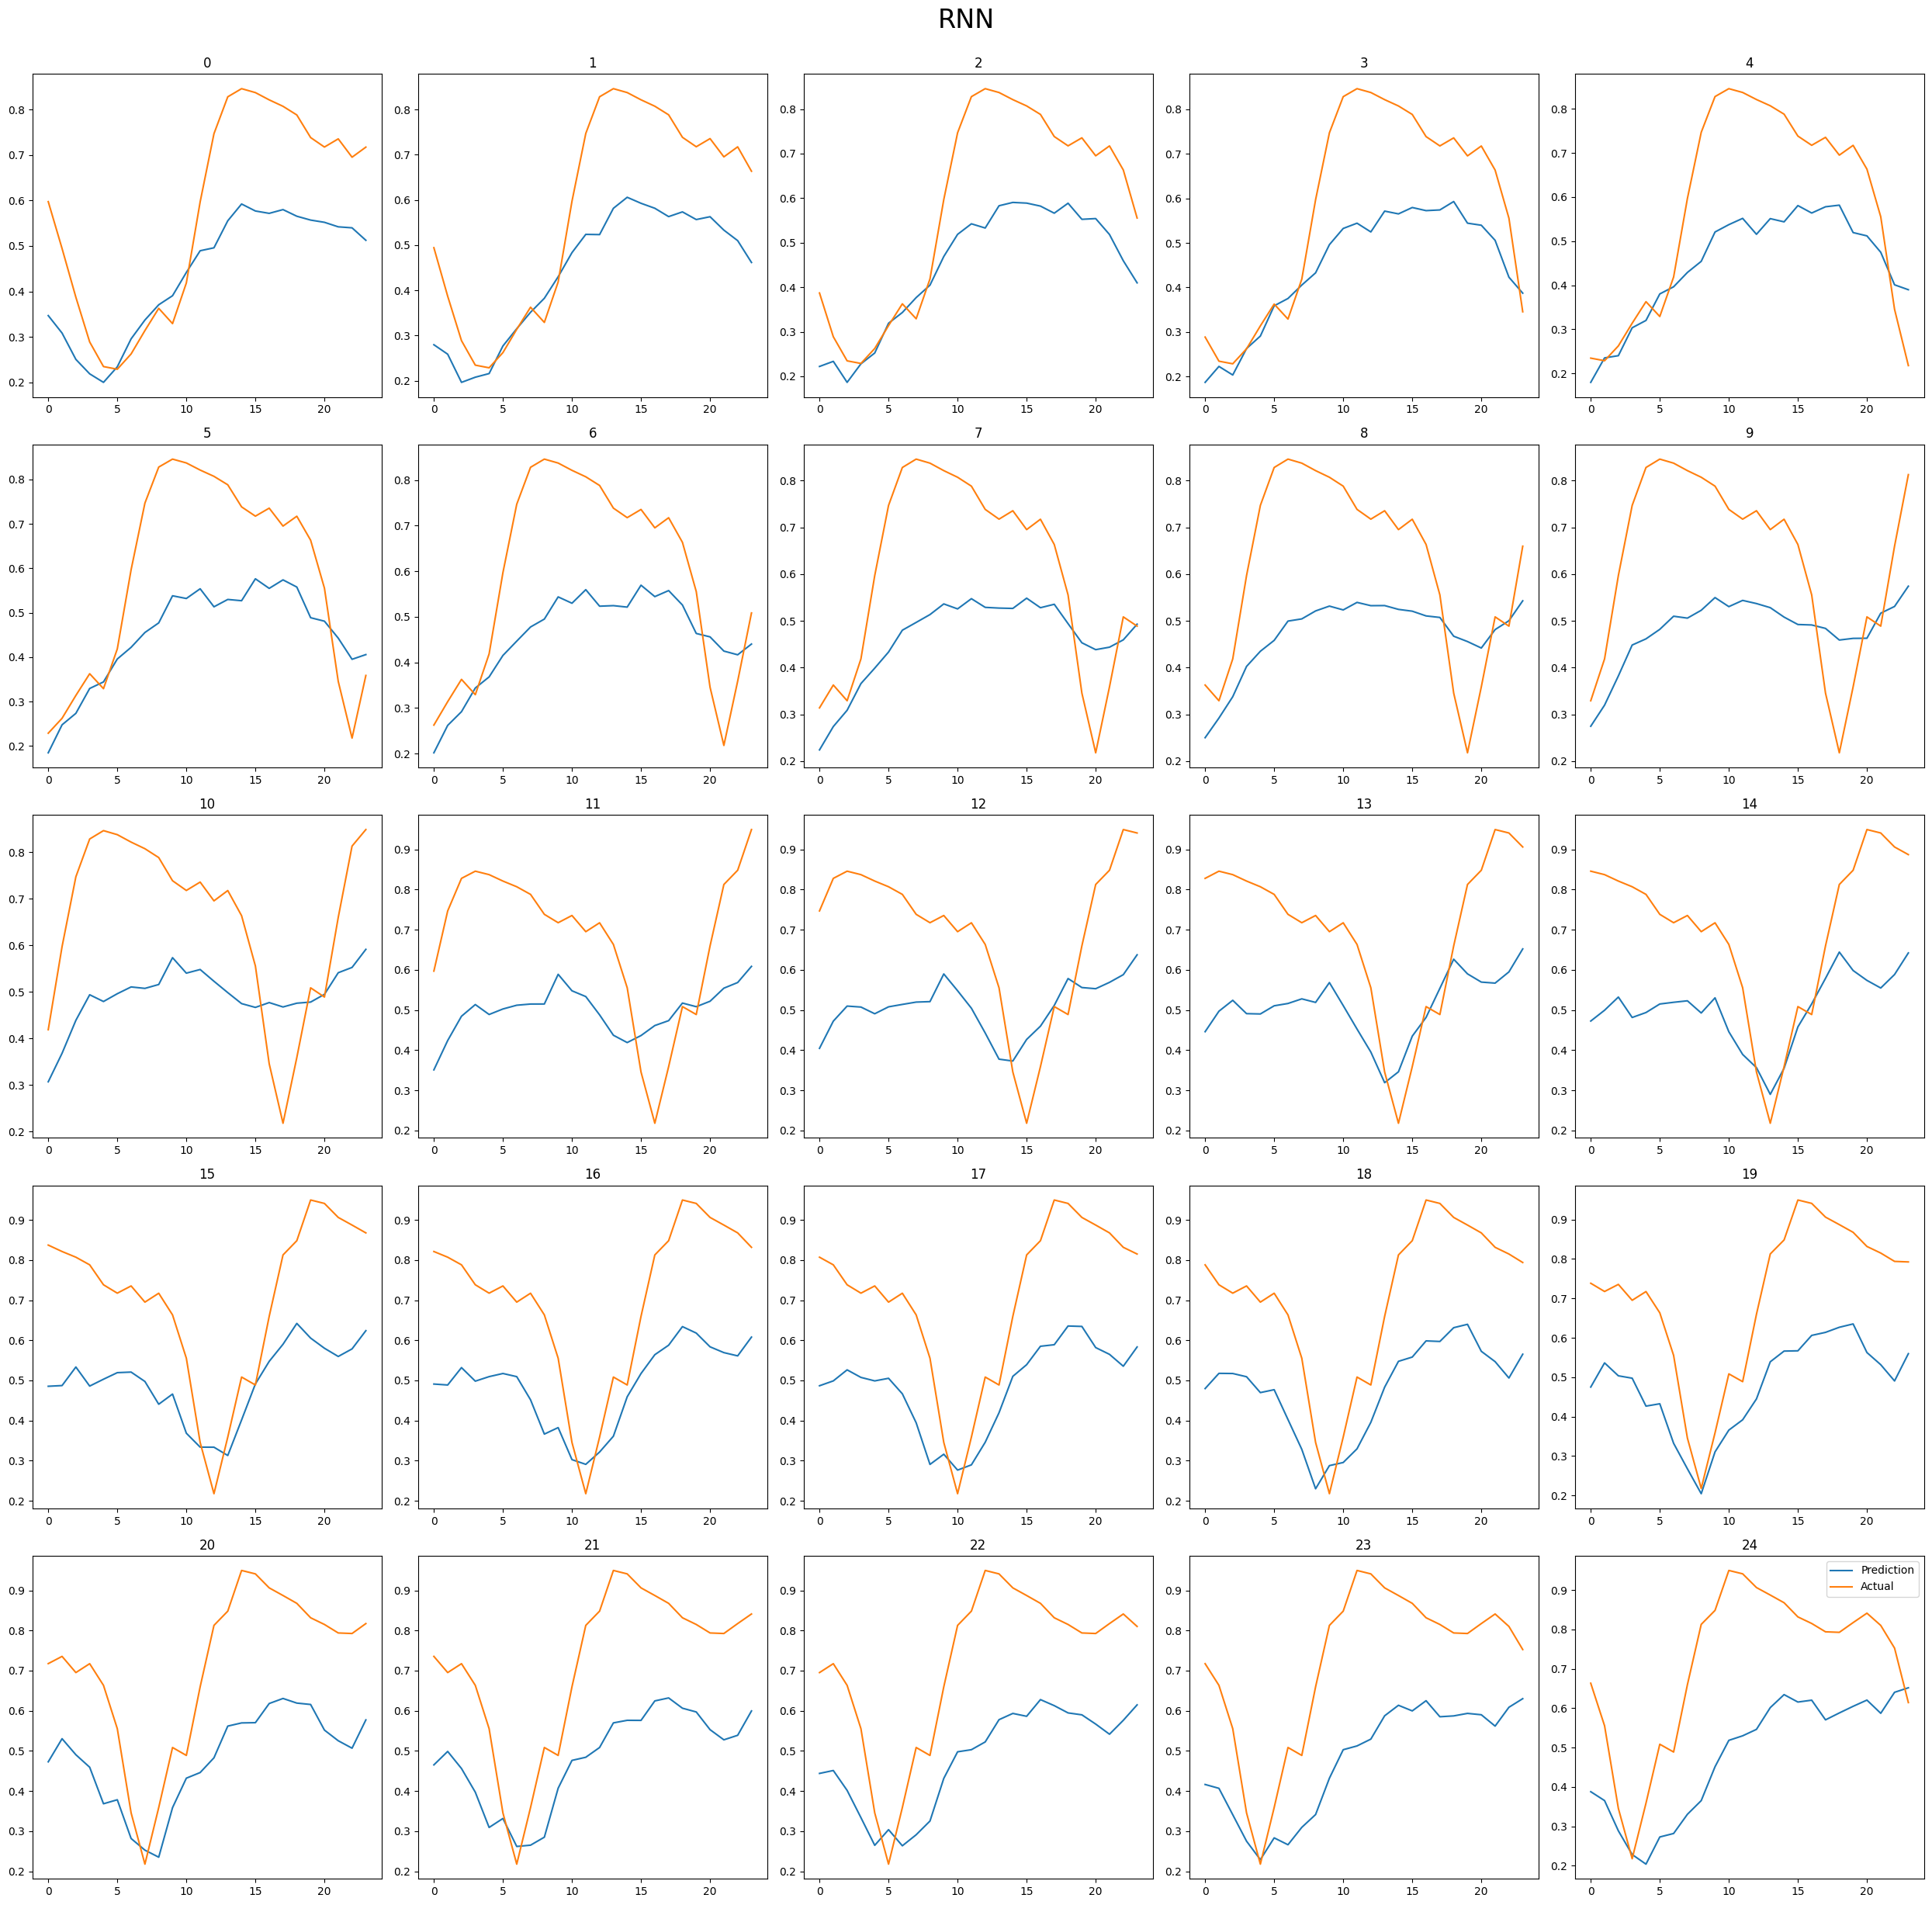

In [13]:
fig, axs = plt.subplots(5, 5, figsize=(25, 25))
axs = axs.flatten()

for i, column in enumerate(predictions):
    ax = axs[i]
    # TODO seems to work but check why column[0]
    ax.plot(column[0], label="Prediction")
    ax.plot(target_variables[i], label="Actual")
    ax.title.set_text(i)

fig.suptitle("RNN", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.legend()
plt.show()

In [14]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = 0
for i in range(len(predictions)):
    print(f'pred={i}, num = {sqrt(mean_squared_error(predictions[i][0], target_variables[i]))}')
    rmse += sqrt(mean_squared_error(predictions[i][0], target_variables[i]))

rmse /= len(predictions)    
print(f"RMSE = {rmse}")

pred=0, num = 0.17520461069656398
pred=1, num = 0.17089152963863768
pred=2, num = 0.16996771692093227
pred=3, num = 0.17219550462775907
pred=4, num = 0.18251141018251876
pred=5, num = 0.19067110428092987
pred=6, num = 0.19752822142316245
pred=7, num = 0.20352241943704155
pred=8, num = 0.21021097356375562
pred=9, num = 0.2181047246224336
pred=10, num = 0.22739893447582885
pred=11, num = 0.24063804883264386
pred=12, num = 0.24463848652094386
pred=13, num = 0.24155581191834558
pred=14, num = 0.2391581769100285
pred=15, num = 0.24035301312379545
pred=16, num = 0.23992191983358885
pred=17, num = 0.24171678942472202
pred=18, num = 0.24200212928088433
pred=19, num = 0.24033943031211427
pred=20, num = 0.24422476052574507
pred=21, num = 0.2507805695192824
pred=22, num = 0.2543881755095013
pred=23, num = 0.26154216343581943
pred=24, num = 0.26284683987425156
RMSE = 0.22249253859564921
